### Clustering

In [1]:
import re
import random
import spacy
import numpy as np
import itertools
import collections
import functools
import operator
import dill as pickle
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import sys

sys.setrecursionlimit(3000)
random.seed(42)

Load data

In [2]:
def load_data(path):
    func_names = []
    func_types = []
    func_comments = []
    with open(path, "r") as file:
        for name, types, comments in (x for x in map(lambda l: l.strip().split("|"), file.readlines()) if len(x) == 3):
            func_types.append(types.split(","))
            func_comments.append(comments.split(","))
            func_names.append(name)
    return func_names, func_types, func_comments

def printk(funcs, k=10, show_sort=True, nmap=None, rand=False):
    print(f"#funcs={len(funcs)}\nfuncs:")
    indices = random.choices(range(len(funcs)), k=k) if rand else range(k)
    print(*((funcs[i], nmap[funcs[i]]) if nmap else funcs[i] for i in indices), sep='\n')
    if show_sort:
        print("\nsorted:", *((f, nmap[f]) if nmap else f for f, _ in zip(sorted(funcs), range(k))), sep='\n')

func_names, func_types, func_comments = load_data("functions.txt")
printk(func_names)

#funcs=3539588
funcs:
Inu_scaled
default_response_type
ComputeNewDominator
set_cost_graph
freednsentry
ti_vsend_sync
k3_dma_probe
CRYP_DataOut
hblank_dma
test_unset_flag

sorted:
$$RTX$$version
$$USBD$$version
$relaytrace$StdcallFunction
$relaytrace$StdcallVersionRange
$relaytrace$Stdcalli386x64
A
A
A
A
A


Drop wrong names

In [3]:
def drop_wrong_names(func_names, func_types, func_comments):
    re_ident = re.compile(rf"^[a-zA-Z_][a-zA-Z_0-9]*$", re.UNICODE)
    func_names, func_types, func_comments = map(
        list, zip(*(itertools.filterfalse(lambda x: not re_ident.fullmatch(x[0]),
                                          zip(func_names, func_types, func_comments)))))
    return func_names, func_types, func_comments

func_names, func_types, func_comments = drop_wrong_names(func_names, func_types, func_comments)
printk(func_names)

#funcs=3521880
funcs:
Inu_scaled
default_response_type
ComputeNewDominator
set_cost_graph
freednsentry
ti_vsend_sync
k3_dma_probe
CRYP_DataOut
hblank_dma
test_unset_flag

sorted:
A
A
A
A
A
A
A
A
A
A


Split names to tokens

In [4]:
def tokenize_funcs(funcs):
    oneword = re.compile(r"^[a-z][a-z0-9]+|[A-Z][A-Z0-9]+$")
    difCase = re.compile(r".+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)")
    under_scores_split = re.compile(r"_")

    tokenized_funcs = []
    for f in funcs:
        if oneword.fullmatch(f):
            tokenized_funcs.append([f])
        elif "_" in f:
            tokenized_funcs.append([w for w in under_scores_split.split(f) if w])
        else:
            tokenized_funcs.append([w.group(0) for w in difCase.finditer(f) if w.group(0)])
    return tokenized_funcs

tokenized_func_names = tokenize_funcs(func_names)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del name2tokens

#funcs=3521880
funcs:
('smtp_get_field', ['smtp', 'get', 'field'])
('set', ['set'])
('freq_rank', ['freq', 'rank'])
('dissect_mms_T_reportSemaphoreEntryStatus_Request_state', ['dissect', 'mms', 'T', 'reportSemaphoreEntryStatus', 'Request', 'state'])
('group_call', ['group', 'call'])
('dissect_rrc_UL_CommonTransChInfo_r4', ['dissect', 'rrc', 'UL', 'CommonTransChInfo', 'r4'])
('deserialize_type', ['deserialize', 'type'])
('devmem_destroy', ['devmem', 'destroy'])
('ngx_kqueue_set_event', ['ngx', 'kqueue', 'set', 'event'])
('imm7', ['imm7'])

sorted:
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])


Drop digits from tokens, convert to low register

In [5]:
def drop_wrong_symbols(func_names, tokenized_func_names, func_types):
    wrong_char = re.compile(r"[\d]")
    tokenized_func_names_ = []
    func_types_ = []
    func_names_ = []
    for i, (name, tokenized_name, types) in enumerate(zip(func_names, tokenized_func_names, func_types)):
        processed_tokens = [wrong_char.sub("", token).lower() for token in tokenized_name if wrong_char.sub("", token)]
        if processed_tokens:
            tokenized_func_names_.append(processed_tokens)
            func_types_.append(types)
            func_names_.append(name)

    return func_names_, tokenized_func_names_, func_types_

func_names, tokenized_func_names, func_types = drop_wrong_symbols(func_names, tokenized_func_names, func_types)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del name2tokens

#funcs=3521613
funcs:
('heaviside', ['heaviside'])
('fx_ibt_r9', ['fx', 'ibt', 'r'])
('multiCursorInit', ['multi', 'cursor', 'init'])
('extract_min_max', ['extract', 'min', 'max'])
('rk_pwm_probe', ['rk', 'pwm', 'probe'])
('gimp_canvas_boundary_set_property', ['gimp', 'canvas', 'boundary', 'set', 'property'])
('nakade_point', ['nakade', 'point'])
('xs100_read', ['xs', 'read'])
('load_fpu', ['load', 'fpu'])
('opexe_2', ['opexe'])

sorted:
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])


Split concatenated words to separate tokens

In [6]:
def create_segment_func(tokenized_func_names, c=1, base=1/26, prior=1e-8):
    word2count = collections.Counter(itertools.chain(*tokenized_func_names))
    total_num_words = sum(word2count.values())
    word2prob1 = {k: v / total_num_words for k, v in word2count.items()}
    ones_length2count = collections.Counter(map(len, (word for word, count in word2count.items() if count == 1)))
    ones_longest = max(ones_length2count)
    ones_num_words = sum(ones_length2count.values())

    # smoothed probability
    def prob(word):
        unseen_estimation = ones_length2count[len(word)] / ones_num_words if len(word) in ones_length2count \
            else ones_length2count[ones_longest] / ones_num_words * base ** (len(word) - ones_longest) \
            if len(word) > ones_longest else base ** len(word)
        return word2prob1[word] if word in word2prob1 else prior * unseen_estimation

    with open("prob.pickle", "wb") as f:
        pickle.dump(prob, f)

    def split(word, start=1, end=20):
        return ((word[:i], word[i:]) for i in range(start, min(len(word) + 1, end)))

    @functools.lru_cache(maxsize=10000)
    def segment(word, maxlen=500):
        if not word:
            return []
        if len(word) > maxlen:
            return segment(word[:maxlen]) + segment(word[maxlen:])
        candidates = ([first] + segment(remaining) for first, remaining in split(word))
        return max(candidates, key=lambda x: functools.reduce(operator.__mul__, map(prob, x), 1))
    return segment

def segmentize_corpus(tokenized_func_names, segmenter):
    tokenized_func_names = [list(itertools.chain(*(segmenter(token) for token in tokens)))
                            for tokens in tokenized_func_names]
    return tokenized_func_names

segmenter = create_segment_func(tokenized_func_names)
words = ["ccfileutils", "setendframeindex", "inneractionframe", "setsearchresolutionsorder",
         "dynamicmeminit", "wakeupiodisableglobal", "getinit", "getinitz"]
print(*((word, segmenter(word)) for word in words), "", sep='\n')
tokenized_func_names = segmentize_corpus(tokenized_func_names, segmenter)

name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del words, name2tokens

('ccfileutils', ['ccfileutils'])
('setendframeindex', ['setendframeindex'])
('inneractionframe', ['inner', 'action', 'frame'])
('setsearchresolutionsorder', ['set', 'search', 'resolutions', 'order'])
('dynamicmeminit', ['dynamicmeminit'])
('wakeupiodisableglobal', ['wakeupiodisable', 'global'])
('getinit', ['get', 'init'])
('getinitz', ['get', 'init', 'z'])

#funcs=3521613
funcs:
('bench_neq_scalar', ['bench', 'neq', 'scalar'])
('validate_chest_type', ['validate', 'chest', 'type'])
('object_get_prop_int8', ['object', 'get', 'prop', 'int'])
('snic_disc_start', ['snic', 'disc', 'start'])
('Object_isPrototypeOf', ['object', 'isprototypeof'])
('ll_conn_iso_group_acquire', ['ll', 'conn', 'iso', 'group', 'acquire'])
('into_string', ['into', 'string'])
('set_i2sstd', ['set', 'is', 'std'])
('level', ['level'])
('add_flash_partition', ['add', 'flash', 'partition'])

sorted:
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A',

Lemmatize tokens

In [7]:
print("#uniq tokens before lemmatizing", len(set(itertools.chain(*tokenized_func_names))), "\n")

def lemmatize_corpus(tokenized_func_names):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    lengths = np.cumsum([0] + list(map(len, tokenized_func_names)))
    flat_tokens = list(itertools.chain(*tokenized_func_names))
    doc = spacy.tokens.Doc(nlp.vocab, words=flat_tokens)
    tokenized_func_names = [[token.lemma_ for token in doc[lengths[i - 1]: lengths[i]]]
                            for i in range(1, len(tokenized_func_names) + 1)]
    return tokenized_func_names

tokenized_func_names = lemmatize_corpus(tokenized_func_names)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)

print("\n#uniq tokens after lemmatizing", len(set(itertools.chain(*tokenized_func_names))), "\n")
del name2tokens

#uniq tokens before lemmatizing 215689 

#funcs=3521613
funcs:
('get_cats', ['get', 'cat'])
('lines_from_files', ['line', 'from', 'file'])
('example_convolution', ['example', 'convolution'])
('new', ['new'])
('udf_allocv', ['udf', 'alloc', 'v'])
('call_sub_orchestrator', ['call', 'sub', 'orchestrator'])
('CountTerminators', ['count', 'terminator'])
('move_next_pile_of_type', ['move', 'next', 'pile', 'of', 'type'])
('download_ipget', ['download', 'ip', 'get'])
('dggevx', ['dggevx'])

sorted:
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])

#uniq tokens after lemmatizing 209084 



Drop rare or uninformative tokens

dict size: 208807

dict:
('get', 270127)
('set', 180381)
('test', 138363)
('init', 80060)
('dissect', 79935)
('read', 65969)
('new', 62397)
('add', 57518)
('write', 56774)
('create', 46703)

reversed dict:
('getmaxdate', 1)
('fastfixmul', 1)
('initiatemasserase', 1)
('getexmodeline', 1)
('vhf', 1)
('busmd', 1)
('subaddresses', 1)
('cuneiform', 1)
('hsei', 1)
('enclosingpolygons', 1)


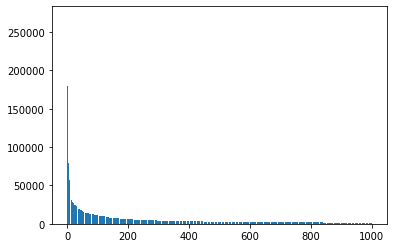

3435010


In [8]:
custom_stop_words = {
    "return", "use", "value", "let", "mut", "type", "sync", "ex", "mc", "sm", "cm", "global",
    "tuple", "call", "crust", "pointer", "vr", "datum", "fill", "ref", "simple",
    "default", "byte", "buff", "null", "numb", "slice", "tx", "ptr", "ext", "content", "cairo",
    "update", "bite", "map", "int", "object", "obj", "type", "bindgen", "const", "constant",
    "one", "run", "change", "make", "op", "entry", "true", "end", "next", "group", "scale",
    "cmd", "point", "float", "apply", "control", "without", "generic", "template",
    "main", "method", "range", "command", "item", "bit", "empty", "current", "target", "fix",
    "offset", "zero", "result", "double", "visit", "option", "opt", "rx", "try", "internal",
    "prepare", "reference", "char", "execute", "exec", "emit", "power", "element", "local",
    "work", "raw", "api", "context", "ctx", "self", "proc", "ctrl", "last", "per", "need",
    "class", "struct", "two", "iter", "base", "impl", "ic", "non", "var", "single", "st",
    "implement", "variant", "\ufeff1", "require", "feature", "mk", "level", "enum", "long",
    "argument", "args", "arg", "must", "brief", "note", "example", "pass", "much", "none", 
    "may", "structure", "foo", "uint", "integer", "bool", "hex", "dt", "app", "instr", "inst",
    "lead", "slot", "rt"
}
stop_words = set(stopwords.words("english")) | custom_stop_words

def prune_vocabulary(func_names, tokenized_func_names, stop_words, max_ct=1e22, min_ct=1, min_len=2, max_len=20):
    word2count = collections.Counter(itertools.chain(*tokenized_func_names))
    word2count = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=True)
                  if min_ct <= v <= max_ct and min_len <= len(k) <= max_len and k not in stop_words}
    vocab_low_to_high = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=False)}
    print(f"dict size: {len(word2count)}\n\ndict:")
    print(*((k, v) for _, (k, v) in zip(range(10), word2count.items())), "\nreversed dict:", sep='\n')
    print(*((k, v) for _, (k, v) in zip(range(10), vocab_low_to_high.items())), sep='\n')

    word2ind = {w: i for w, i in zip(word2count.keys(), itertools.count())}
    ind2count = {word2ind[w]: freq for (w, freq), _ in zip(word2count.items(), range(1000))}
    plt.bar(ind2count.keys(), ind2count.values())
    plt.show()

    tokenized_func_names_ = []
    func_names_ = []
    for i, (name, tokenized_name) in enumerate(zip(func_names, tokenized_func_names)):
        processed_tokens = [token for token in tokenized_name if token in word2count]
        if processed_tokens:
            tokenized_func_names_.append(processed_tokens)
            func_names_.append(name)

    return func_names_, tokenized_func_names_

func_names, tokenized_func_names = prune_vocabulary(func_names, tokenized_func_names, stop_words)
print(len(tokenized_func_names))

In [9]:
classes = {
    "destroy": [
        "clean", "cleanup", "clear", "remove", "drop", "reset", "free", "shutdown", "bite", "finish", "erase",
        "disable", "delete", "del", "destroy", "stop", "release", "leave", "exit", "sub", "unregister", "cancel",
        "suspend", "abort", "deinit", "finalize", "escape", "gc"
    ],
    "init": [
        "init", "initialize", "activate", "new", "register", "reg", "create", "gen", "generate", "start", "enable",
        "setup", "build", "begin", "resume", "construct", "install", "def", "define", "refresh", "fini", "decl"
    ],
    "get": [
        "get", "take", "pop", "select", "attr", "attribute", "field", "param", "parameter", "params",
        "property", "prop"
    ],
    "rrc": [
        "dissect", "lte", "rrc", "pdu", "nr", "cell", "nbap", "rnsap", "srsran"
    ],
    "log": [
        "log", "config", "cfg", "conf", "configure", "dump", "store", "commit", "save", "specify", "setting", "env",
        "report"
    ],
    "test": [
        "test", "detect", "layout", "bench", "validate", "check", "verify", "complete", "probe", "match", "valid",
        "control", "success", "fail", "invalid", "debug", "br", "trace"
    ],
    "database": [
        "sqlite", "query", "table", "db", "schema", "record", "transaction"
    ],
    "network": [
        "network", "net", "send", "snd", "recv", "rcv", "receive", "buf", "buff", "request", "req", "title",
        "message", "msg", "packet", "header", "hdr", "link", "channel", "page", "port", "fetch", "client", "connect",
        "server", "udp", "http", "ngx", "pdu", "response", "address", "addr", "ip", "bind", "attach", "detach",
        "socket", "sock", "host", "async", "session", "tcp", "ack", "post", "poll", "bridge", "proto", "service",
        "peer", "url", "ie", "tls", "ipv", "vlan", "load", "accept", "proxy", "connection", "conn", "disconnect",
        "reply", "body", "reflect", "ieee", "src", "dst", "protocol", "policy", "dispatch", "dns", "org", "web",
        "submit", "remote", "rpc", "grpc"
    ],
    "file": [
        "read", "reader", "write", "writer", "io", "file", "filename", "fd", "open", "close", "pipe", "seek", "doc",
        "desc", "descriptor"
    ],
    "string": [
        "parse", "parser", "str", "string", "text", "encode", "encoder", "enc", "decode", "pack", "unpack",
        "input", "line", "filter", "reg", "json", "xml", "pdf", "replace", "utf", "font", "split", "pattern"
    ],
    "format": [
        "convert", "to", "format", "fmt", "serialize", "deserialize", "transform", "normalize", "wrap", "align",
        "translate", "clip"
    ],
    "compress": [
        "compress", "compression", "compressor", "gzip", "zip", "bz", "gz", "tar", "xz", "archive", "lzma", "extract",
        "metadata"
    ],
    "error": [
        "error", "assert", "eq", "warn", "warning", "message", "msg", "err", "handle", "parse", "syntax", "trigger"
    ],
    "device": [
        "device", "dev", "dma", "dm", "channel", "ioctl", "driver", "drv", "pci", "pcie", "usb", "gpio", "phy", "mac",
        "intel", "mlxsw", "ib", "hal", "bus", "adc", "pcm", "tegra", "eth", "rte", "mesh", "dp", "spi", "sp",
        "amdgpu", "lpfc", "rtl", "sd", "arm", "pin", "fw", "omap", "flash", "mouse", "disk", "partition", "ixgbe",
        "ble", "bt", "native", "endpoint", "arch"
    ],
    "os": [
        "system", "sys", "os", "xfs", "nfs", "btrfs", "mount", "mkdir", "kernel", "engine", "inode",
        "core", "basic", "dfs"
    ],
    "parallel": [
        "thread", "process", "cpu", "hw", "spawn", "schedule", "scheduler", "task", "job", "batch", "worker",
        "master", "slave"
    ],
    "async": [
        "block", "lock", "mutex", "unlock", "async"
    ],
    "signal": [
        "handle", "signal", "interrupt", "handler", "irq", "intr", "hook", "cb", "callback", "action"
    ],
    "event": [
        "event", "state", "mode", "mod", "wait", "ready", "idle", "complete", "status", "code",
        "flag", "track", "notify", "atomic", "pend", "monitor", "handle"
    ],
    "time": [
        "time", "timer", "clock", "clk", "timeout", "wait", "rtc", "rte", "delay", "ms", "sec", "date", "sleep",
        "tick", "timestamp", "duration"
    ],
    "copy": [
        "copy", "cp", "move", "swap", "merge", "clone", "transfer"
    ],
    "path": [
        "path", "file", "dir", "directory", "root", "child", "parent"
    ],
    "graphic": [
        "show", "draw", "paint", "print", "output", "window", "win", "display", "frame", "flush", "video", "image",
        "stream", "render", "color", "gimp", "tool", "gl", "bound", "box", "gui", "view", "cursor", "button",
        "ui", "screen", "interface", "rgb", "menu", "texture", "pixel", "gfx", "widget", "shader", "ff", "wm",
        "style", "rect", "msa", "rotate", "angle", "degree", "deg", "snapshot", "scroll", "codec"
    ],
    "help": [
        "info", "information", "help", "helper", "lookup", "version", "support", "stats", "stat", "serial",
        "description"
    ],
    "matrix": [
        "matrix", "mm", "mul", "mask", "row", "col", "column", "vector", "vec", "height", "width"
    ],
    "container": [
        "queue", "list", "array", "vector", "vec", "cache", "heap", "fifo", "bitmap", "max", "min",
        "sum", "contain", "len", "length", "find", "search", "pattern", "match", "scan", "num", "size", "common",
        "position", "pos", "resize", "add", "insert", "put", "push", "append", "stack", "counter", "container", "count",
        "iterator", "iter", "reverse"
    ],
    "resource": [
        "mem", "memory", "ram", "space", "alloc", "allocate", "allocation", "free", "resource", "buf", "buffer",
        "chunk", "volume", "capacity", "limit", "pool", "storage", "usage", "available"
    ],
    "sort": [
        "sort", "order", "dissect", "loop", "seq", "skip", "sequence"
    ],
    "security": [
        "hash", "sign", "signature", "digest", "resolve", "crypto", "sha", "encrypt", "decrypt", "aes", "crypt", "md",
        "cipher", "cert", "ssl", "auth", "password", "secure", "key", "account", "login", "user", "acl", 
        "profile", "allow", "private", "secret", "public", "access", "crc", "safe"
    ],
    "id": [
        "key", "id", "find", "index", "idx", "token", "tag"
    ],
    "eq": [
        "match", "eq", "equal", "compare", "cmp", "diff", "patch", "comp"
    ],
    "calc": [
        "compute", "calc", "calculate", "eval", "expression", "expr"
    ],
    "audio": [
        "audio", "capture", "volume", "codec", "hdmi", "sound", "snd", "radio", "vst", "midi", "track", "preset", "mic",
        "stream", "channel"
    ],
    "rand": [
        "random", "rand", "rng", "seed", "generate", "gen", "uniform", "sample"
    ],
    "library": [
        "export", "lib", "library", "symbol", "dyn", "fun", "fn", "func", "function", "import", "std",
        "dynamic", "module", "plugin", "package"
    ],
    "vm": [
        "vm", "kvm", "vcpu", "virtio", "virtual", "emulate", "kvmppc", "qemu"
    ],
    "graph": [
        "graph", "edge", "node", "vertex", "link", "neighbor", "tree", "child", "parent"
    ],
    "intrinsic": [
        "mm", "epi", "epu", "intr", "maskz", "anybitmemory", "xmmregister", "ymm", "avx"
    ],
    "speed":  [
        "speed", "perf", "rate", "fast", "velocity", "performance", "quick",
    ],
    "location": [
        "location", "distance", "position", "pos", "place", "coord", "region"
    ],
    "name": [
        "name", "rename", "alias"
    ],
    "tmp": [
        "temp", "tmp", "temporary"
    ],
    "assign": [
        "label", "assign", "mark", "cluster", "segment", "set"
    ],
    "term": [
        "term", "terminal", "tty", "sh", "shell", "cli", "tui", "console", "uart"
    ],
    "vcs": [
        "vcs", "svn", "git", "github", "branch", "repository", "repo", "merge", "commit"
    ],
    "bin": [
        "bin", "binary", "elf", "pe", "executable"
    ]
}

if "class2funcs" not in locals().keys():
    class2funcs = {c: [] for c in classes}

print(len(classes))

46


In [10]:
def match(k, l):
    return k >= 0.5 * l


def classify(func_names, tokenized_func_names, classes, class2funcs):
    tokenized_func_names_ = []
    func_names_ = []
    for name, tokenized_name in zip(func_names, tokenized_func_names):
        scores = {c: 0 for c in classes}
        for c, cl in classes.items():
            for tok in tokenized_name:
                if tok in cl:
                    scores[c] += 1

        scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
        candidates = []
        cand_score = 0
        for c, sc in scores.items():
            is_match = match(sc, len(tokenized_name))
            if is_match and len(candidates) == 0:
                cand_score = sc
                candidates.append(c)
            else:
                if is_match and sc == cand_score:
                    candidates.append(c)
                else:
                    break

        if len(candidates) == 0:
            tokenized_func_names_.append(tokenized_name) 
            func_names_.append(name)
        else:
            c = random.choice(candidates)
            class2funcs[c].append((name, tokenized_name))

    return func_names_, tokenized_func_names_

func_names, tokenized_func_names = classify(func_names, tokenized_func_names, classes, class2funcs)
print(len(tokenized_func_names))

2038035


In [11]:
print(*[(c, len(f)) for c, f in class2funcs.items()], sep="\n")

('destroy', 67782)
('init', 123173)
('get', 88563)
('rrc', 25665)
('log', 22953)
('test', 99206)
('database', 10299)
('network', 119825)
('file', 72458)
('string', 70026)
('format', 18441)
('compress', 5522)
('error', 26895)
('device', 31137)
('os', 9123)
('parallel', 17180)
('async', 10853)
('signal', 24571)
('event', 32356)
('time', 19933)
('copy', 14073)
('path', 17324)
('graphic', 72890)
('help', 14617)
('matrix', 14546)
('container', 110925)
('resource', 28498)
('sort', 11603)
('security', 36603)
('id', 25627)
('eq', 12029)
('calc', 9343)
('audio', 7200)
('rand', 9896)
('library', 15739)
('vm', 1844)
('graph', 12226)
('intrinsic', 5918)
('speed', 2299)
('location', 4854)
('name', 10178)
('tmp', 745)
('assign', 52198)
('term', 3975)
('vcs', 3475)
('bin', 2389)
